In [35]:
%%html
<style>
    @font-face {
        font-family: "Computer Modern";
        src: url('http://mirrors.ctan.org/fonts/cm-unicode/fonts/otf/cmunss.otf');
    }
    @font-face {
        font-family: "Computer Modern";
        src: url('http://mirrors.ctan.org/fonts/cm-unicode/fonts/otf/cmunsx.otf');
        font-weight: bold;
    }
    @font-face {
        font-family: "Computer Modern";
        src: url('http://mirrors.ctan.org/fonts/cm-unicode/fonts/otf/cmunsi.otf');
        font-style: italic, oblique;
    }
    @font-face {
        font-family: "Computer Modern";
        src: url('http://mirrors.ctan.org/fonts/cm-unicode/fonts/otf/cmunbxo.otf');
        font-weight: bold;
        font-style: italic, oblique;
    }
    .text_cell { font-family: "Computer Modern", "Palatino", "Palatino Linotype", serif; }
    .code_cell:first-child { display: none; } 
    h1, h2, h3, h4 { text-align: center; }
</style>

# Chaotic Behavior of the Triple Pendulum
## A Computational Approach

#### Rachel Bass and Cory McCartan

In [64]:
%%capture

# Set-up and formatting

%pylab inline
from scipy.integrate import odeint 
import scipy.signal as signal
# picture configuration
matplotlib.rcParams["savefig.dpi"] = 300
matplotlib.rcParams["savefig.bbox"] = "tight"

from IPython.core.interactiveshell import InteractiveShell
%config InlineBackend.figure_format = "retina"  # higher-def plots

## Setup

### Equations of Motion

We begin by defining the constants for our system. The equations of motion for the triple pendulum are 
\begin{equation}
\begin{pmatrix}
    \ddot\phi_1 \\
    \ddot\phi_2 \\
    \ddot\phi_3
\end{pmatrix} = \begin{pmatrix}
    3                    & 2\cos(\phi_1-\phi_2) & \cos(\phi_1-\phi_3) \\
    2\cos(\phi_1-\phi_2) & 2                    & \cos(\phi_2-\phi_3) \\
    \cos(\phi_1-\phi_3)  & \cos(\phi_2-\phi_3)  & 1                   \\
\end{pmatrix}^{-1}
\begin{pmatrix}
    -\dot\phi_3^2\sin(\phi_1-\phi_3) -2\dot\phi_2^2\sin(\phi_1-\phi_2)
        -\frac{3g}{l}\sin\phi_1 \\
    -\dot\phi_3^2\sin(\phi_2-\phi_3) + 2\dot\phi_1^2\sin(\phi_1-\phi_2)
        -\frac{2g}{l}\sin\phi_2 \\
    \dot\phi_2^2\sin(\phi_2-\phi_3) +\dot\phi_1^2\sin(\phi_1-\phi_3)
        -\frac{g}{l}\sin\phi_3
\end{pmatrix},
\end{equation}
which as we can see depend only on the angles and angular velocities of the masses, as well as $g$ and $l$.

In [37]:
# Constants
g = 9.8 # m/s^2
l = 0.5 # m

In [38]:
# Mechanics of triple pendulum system.
# Passed into odeint function.
def triple_pendulum(r, t, g, l):
    phi_1, phi_2, phi_3, dphi_1, dphi_2, dphi_3 = r # unpack variables
    
    # precalculate trig functions
    cos_1_2 = cos(phi_1 - phi_2)
    cos_1_3 = cos(phi_1 - phi_3)
    cos_2_3 = cos(phi_2 - phi_3)
    sin_1_2 = sin(phi_1 - phi_2)
    sin_1_3 = sin(phi_1 - phi_3)
    sin_2_3 = sin(phi_2 - phi_3)
    
    # define arrays and vectors
    A = array([[3,         2*cos_1_2, cos_1_3],
               [2*cos_1_2, 2,         cos_2_3],
               [cos_1_3,   cos_2_3,   1      ]])
    
    B = array([-dphi_3**2 * sin_1_3 - 2*dphi_2**2 * sin_1_2 - 3*g*sin(phi_1)/l,
               -dphi_3**2 * sin_2_3 + 2*dphi_1**2 * sin_1_2 - 2*g*sin(phi_2)/l,
                dphi_2**2 * sin_2_3 +   dphi_1**2 * sin_1_3 -   g*sin(phi_3)/l])
    
    ddphi =  matmul(inv(A), B) # angular acceleration
    return concatenate(([dphi_1, dphi_2, dphi_3], ddphi)) # tack on angular velocity

In [39]:
def solve_triple_pendulum(r0, tmax, l=l, dt = 0.001):
    t = arange(0, tmax, dt)
    solution = odeint(triple_pendulum, r0, t, args = (g, l))
    
    
    phi_1 = solution[:, 0]
    phi_2 = solution[:, 1]
    phi_3 = solution[:, 2]
    
    dphi_1 = solution[:, 3]
    dphi_2 = solution[:, 4]
    dphi_3 = solution[:, 5]
    
    return t, phi_1, phi_2, phi_3, dphi_1, dphi_2, dphi_3

### Plotting

We also create some helper functions to plot solutions to the triple pendulum system.  In addition to viewing the three angles over time, we'd like to be able to see the trajectories the masses trace out, as well as a phase space plot for each mass.

In [54]:
# Plots phi_1, phi_2, and phi_3 over time.
def time_plot(solution, subtitle = ""):
    t, phi_1, phi_2, phi_3, dphi_1, dphi_2, dphi_3 = solution
    
    deg_1 = phi_1 * 180 / pi
    deg_2 = phi_2 * 180 / pi
    deg_3 = phi_3 * 180 / pi
    
   
    figsize(15, 7)
    fig = figure()
          
    plot(t, deg_1, "-g", label="First pendulum")
    plot(t, deg_2, "--m", label="Second pendulum")
    plot(t, deg_3, ":k", label="Third pendulum")
    # titles and labels
    title("Pendulum Angles over Time\n{}".format(subtitle))
    xlabel("Time (s)")
    ylabel("Angle (deg)")
    # legend
    legend()
    
    return fig
    
    
# Plots the pendulum trajectory in x-y space. NOT scaled appropriately to length l
def trajectory_plot(solution, subtitle = ""):
    t, phi_1, phi_2, phi_3, dphi_1, dphi_2, dphi_3 = solution
    
    x1 = sin(phi_1)
    x2 = x1 + sin(phi_2)
    x3 = x2 + sin(phi_3)
    y1 = -cos(phi_1)
    y2 = y1 - cos(phi_2)
    y3 = y2 - cos(phi_3)
    
    figsize(15, 7)
    fig = figure()
    
    axvline(x = 0, color = "#bbbbbb")#vertical light gray line
    axhline(y = 0, color = "#bbbbbb")#horizontal light gray line
    
    plot(x1, y1, "-g", label = "First Pendulum")
    plot(x2, y2, "--m", label = "Second Pendulum")
    plot(x3, y3, ":k", label = "Third Pendulum")
    
    title("Pendulum Trajectories over Time\n{}".format(subtitle))
    xlabel("x / l")
    ylabel("y / l")
    legend()
    
    margins(y = 0.1)
    
    return fig
    
# Plots the phase space trajectories of the masses
def phase_space_plot(solution, subtitle = ""):
    t, phi_1, phi_2, phi_3, dphi_1, dphi_2, dphi_3 = solution
    
    fig = figure()
    title("Phase Space Trajectories of Masses\n{}\n\n".format(subtitle))
    axis("off")
    
    plot1 = fig.add_subplot(131)
    axvline(x = 0, color = "#bbbbbb")# vertical light gray line
    axhline(y = 0, color = "#bbbbbb")# horizontal light gray line
    plot(phi_1, dphi_1, "k")
    title("First Pendulum")
    xlabel("Angle")
    ylabel("Angular Velocity (1/s)")
    
    plot2 = fig.add_subplot(132)
    axvline(x = 0, color = "#bbbbbb")# vertical light gray line
    axhline(y = 0, color = "#bbbbbb")# horizontal light gray line
    plot(phi_2, dphi_2, "k")
    title("Second Pendulum")
    xlabel("Angle")
    
    plot3 = fig.add_subplot(133)
    axvline(x = 0, color = "#bbbbbb")# vertical light gray line
    axhline(y = 0, color = "#bbbbbb")# horizontal light gray line
    plot(phi_3, dphi_3, "k")
    title("Third Pendulum")
    xlabel("Angle")
    
    tight_layout()
    
    return fig

## Verification

We want to check that the `triple_pendulum` function accurately captures the dynamic of the system. Since there is no analytic solution to the triple pendulum, we can do this by checking a few limiting cases, and checking that energy is conserved generally.

### No initial displacement or angular velocity

We first conduct a sanity check by ensuring that when $\phi_i(0)=0$ and $\dot\phi_i(0)=0$, the pendulum system remains motionless.

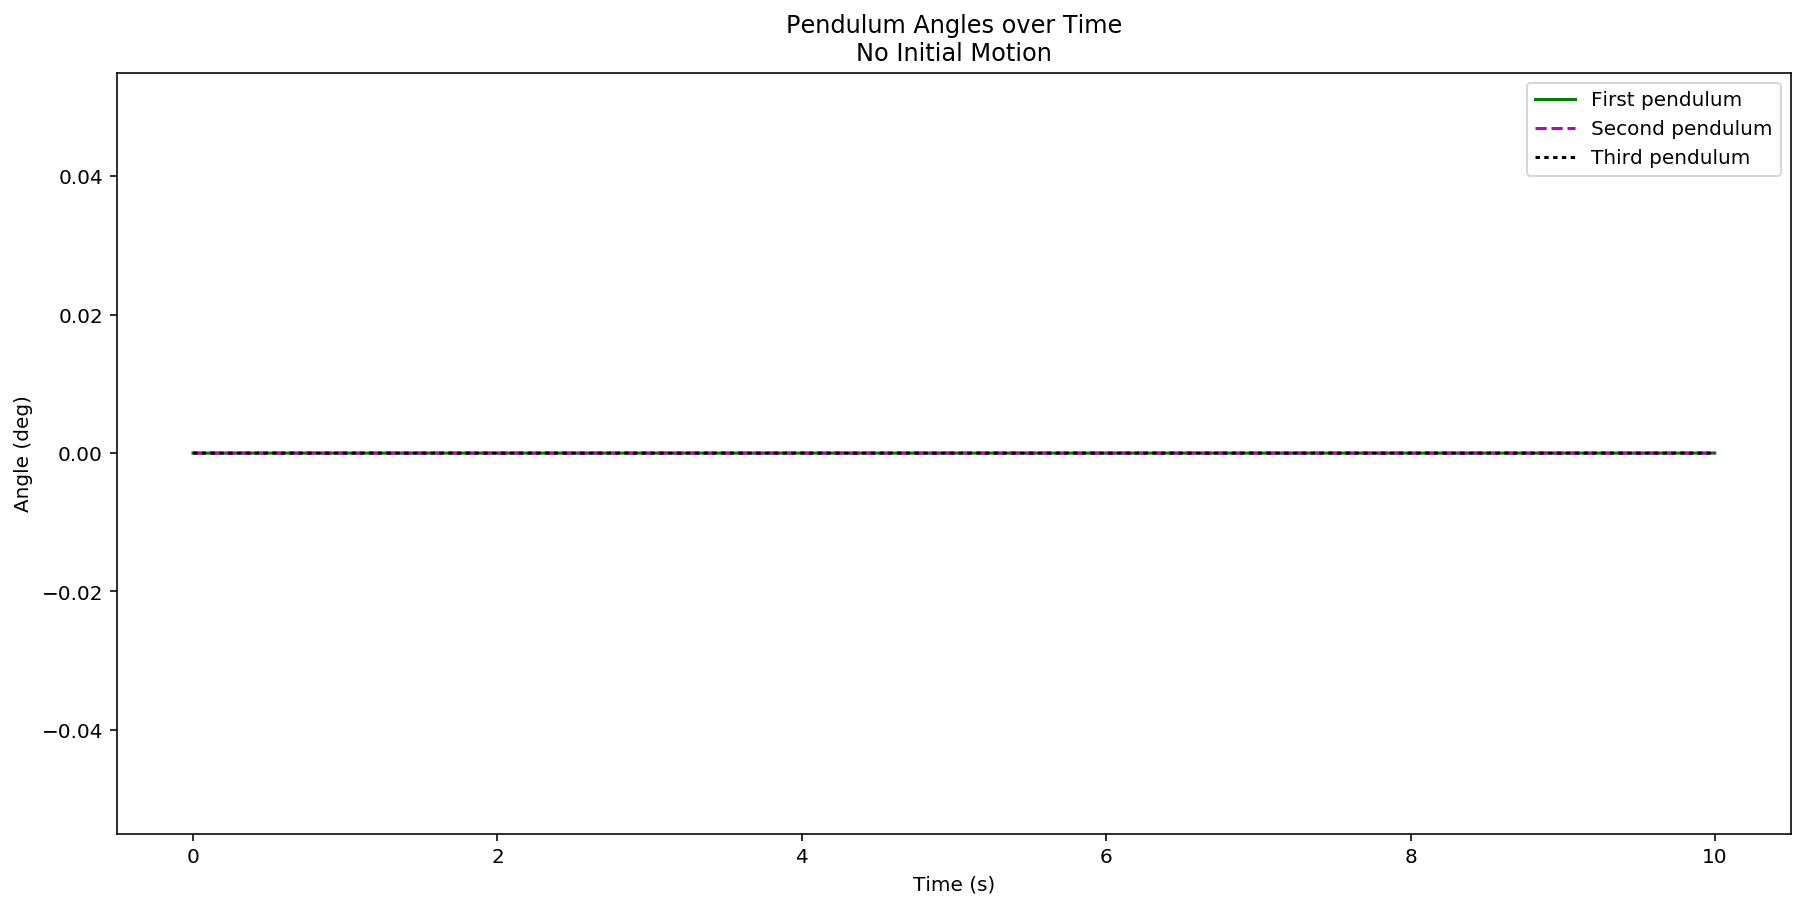

In [41]:
solution = solve_triple_pendulum([0, 0, 0, 0, 0, 0], tmax=10)
time_plot(solution, "No Initial Motion").savefig("no_motion_time_sol.png")

### Energy Conservation

We can also check that energy is conserved.  We will start the bottom pendulum with a moderate amount of initial angular velocity ($\dot\phi_3(0)=7\ s^{-1}$), but leave the other intial conditions unchanged.

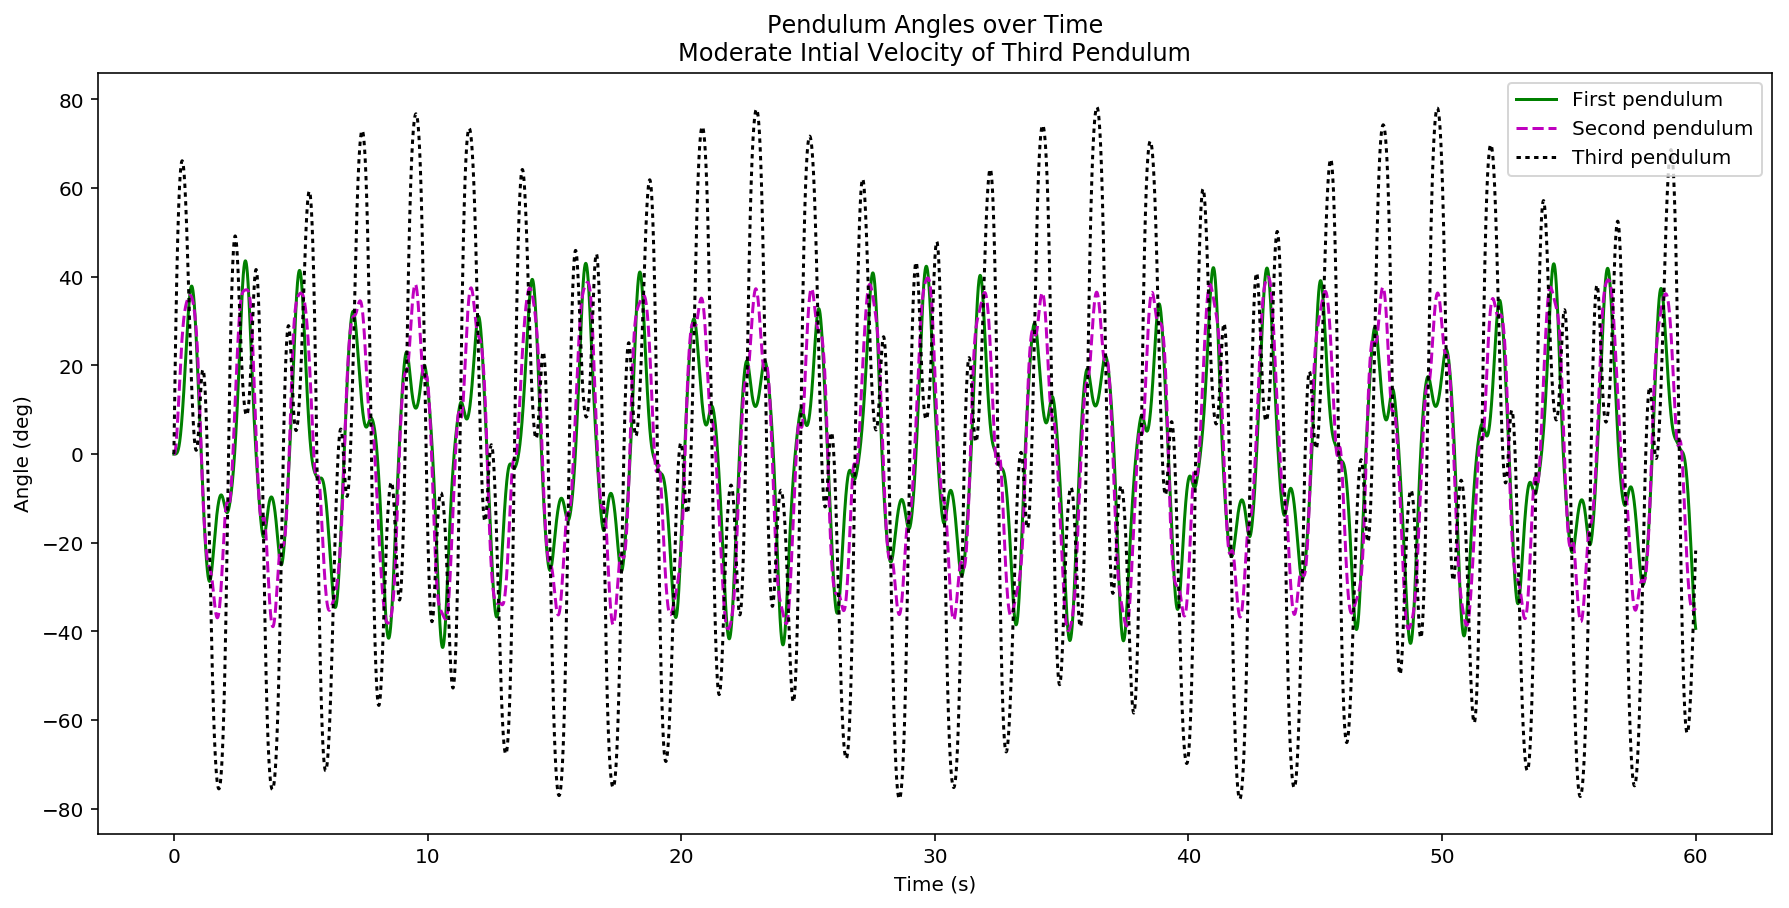

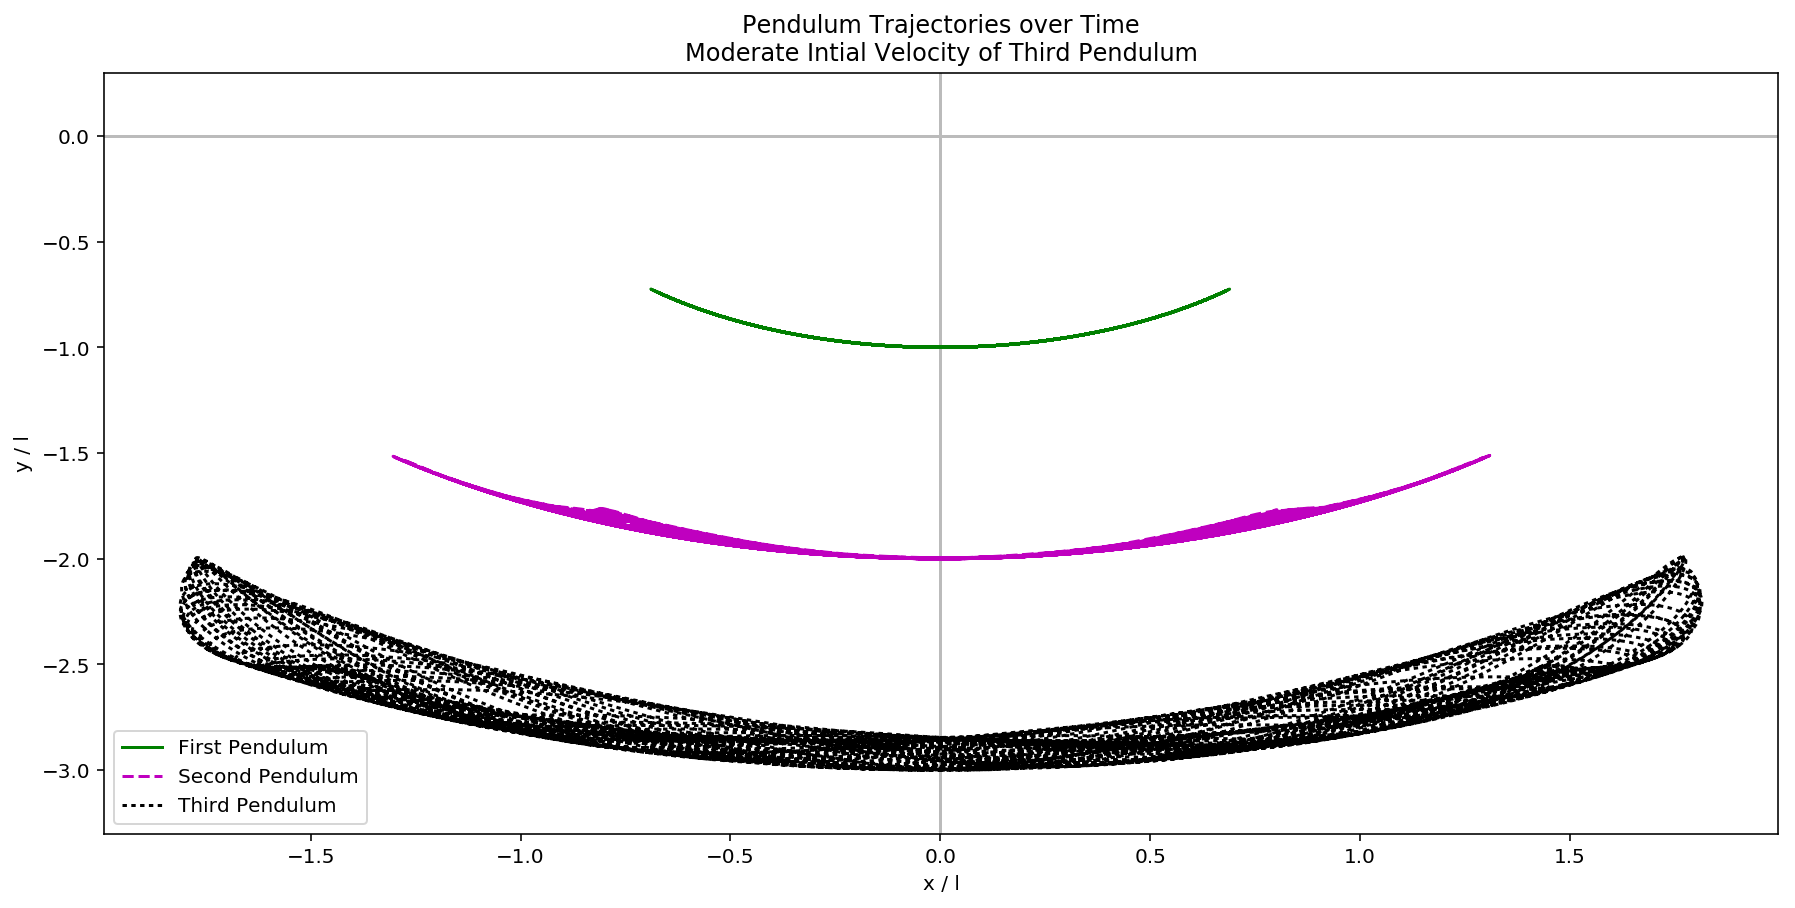

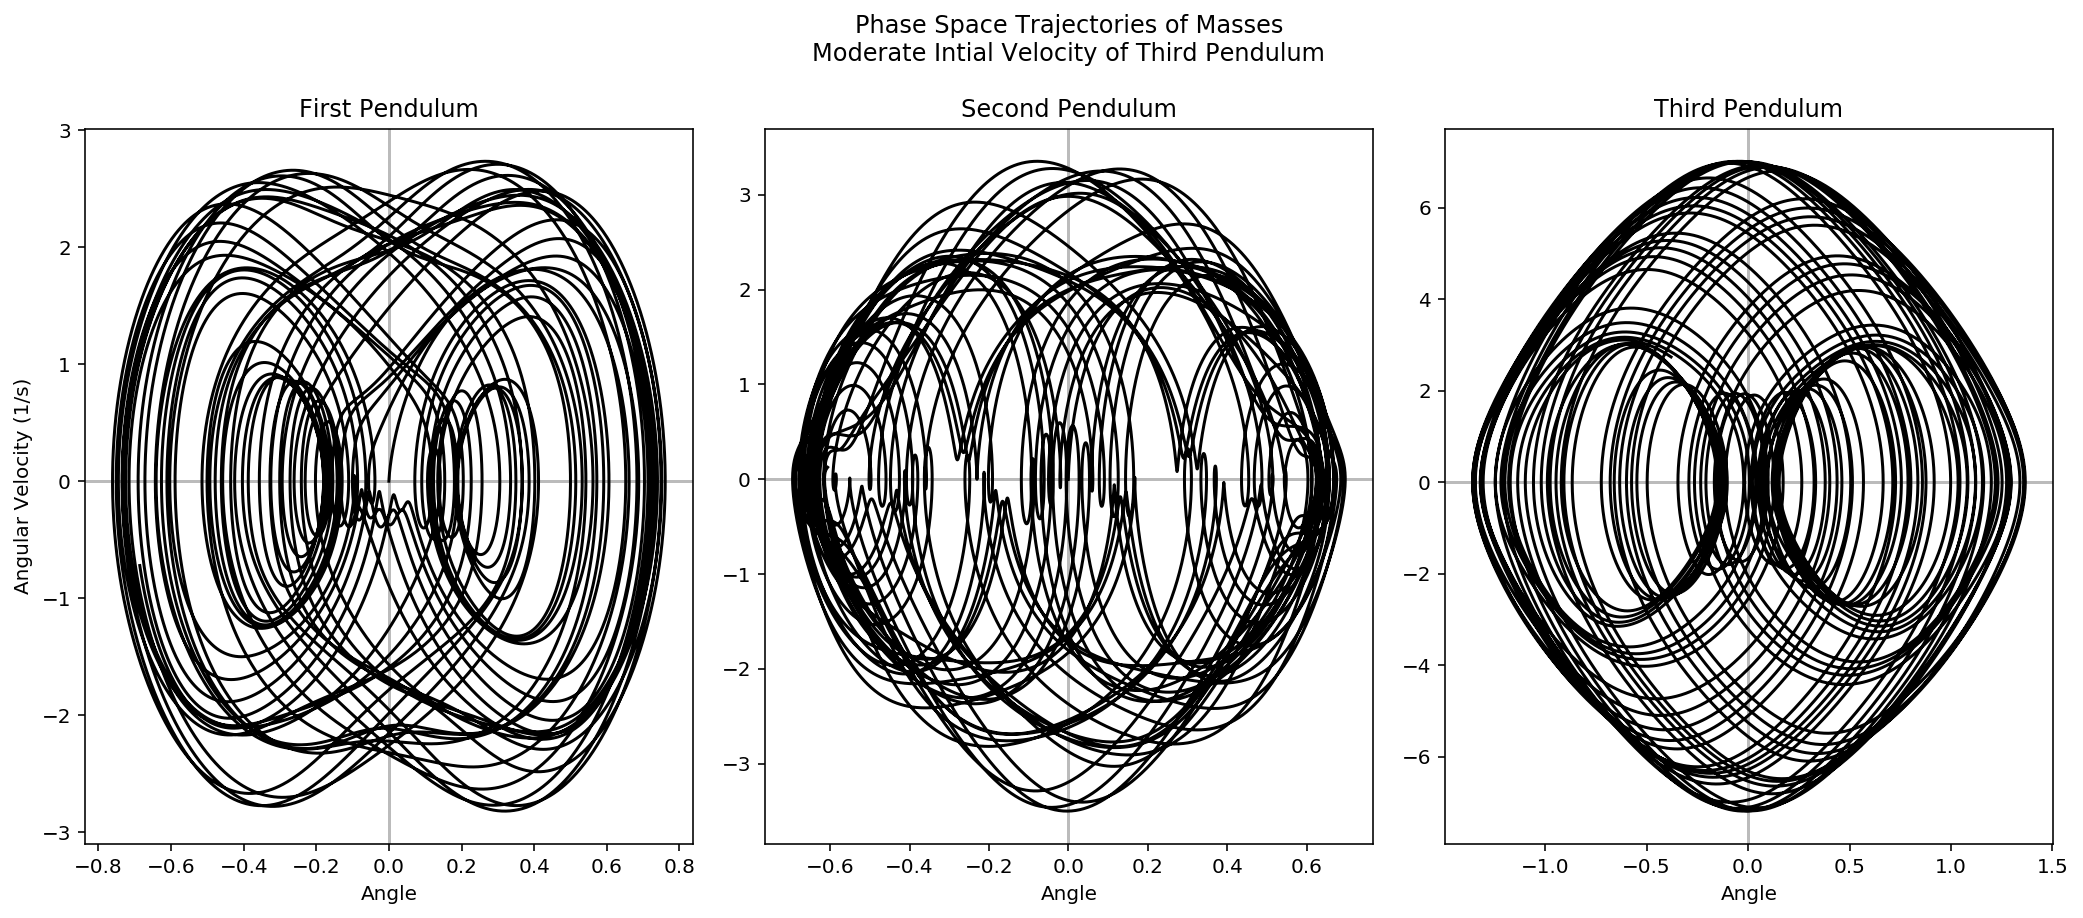

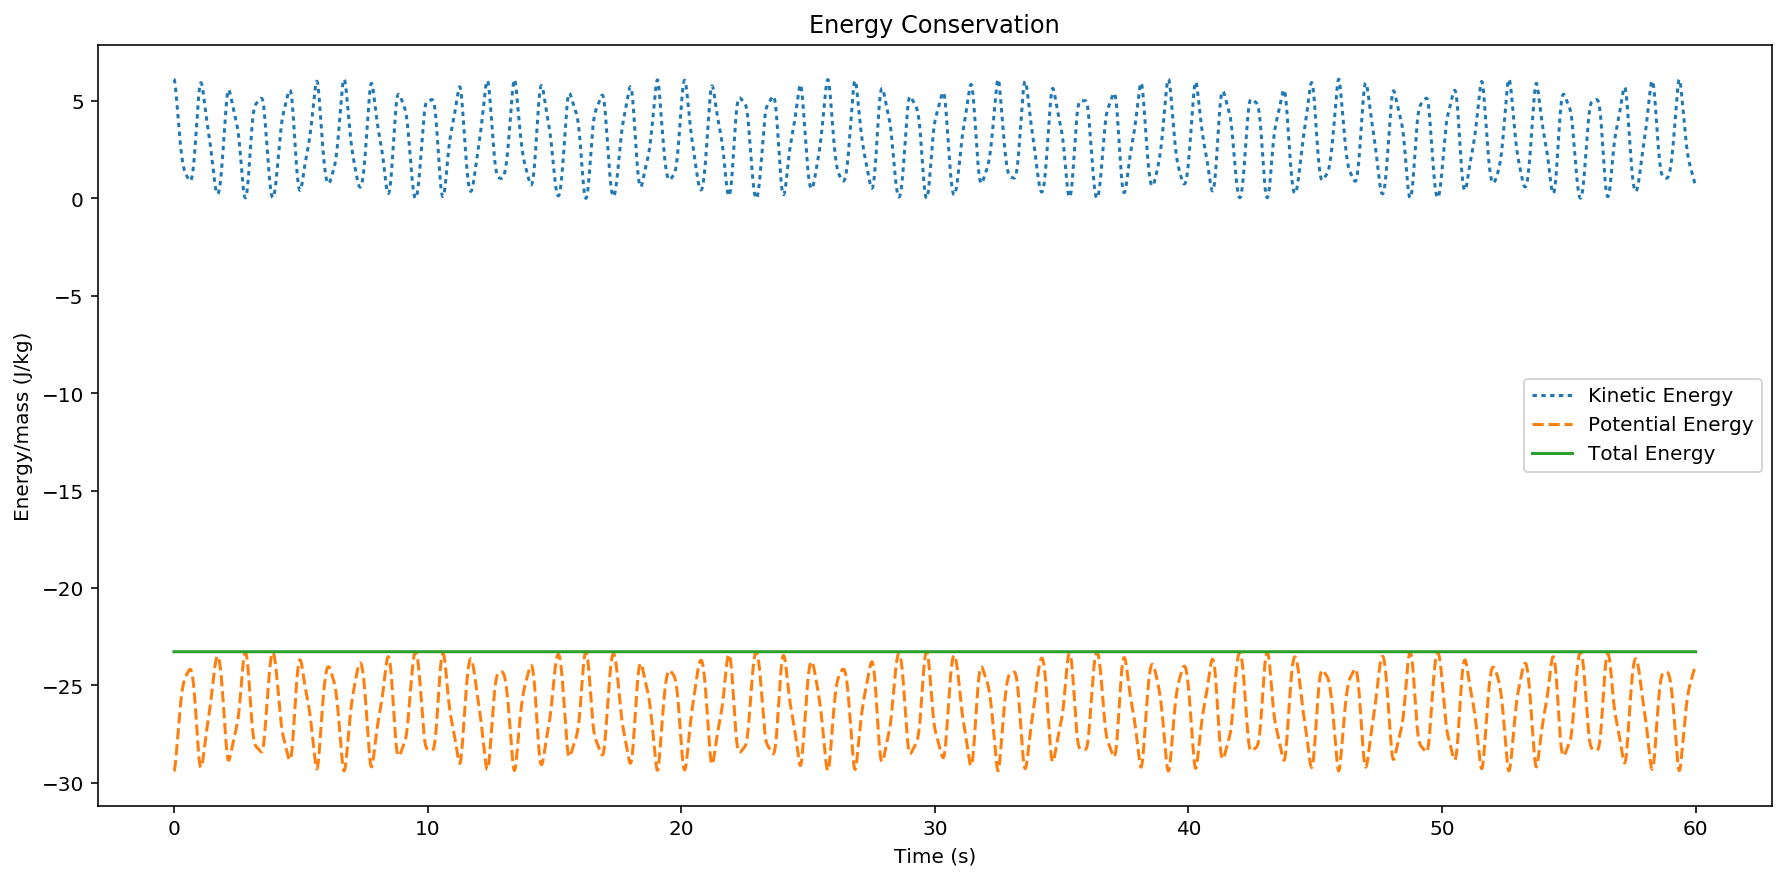

In [65]:
solution = solve_triple_pendulum([0, 0, 0, 0, 0, 7], tmax = 60)

time_plot(solution, "Moderate Intial Velocity of Third Pendulum").savefig("figures/moderate_velocity_time_sol.png")
trajectory_plot(solution, "Moderate Intial Velocity of Third Pendulum").savefig("figures/moderate_velocity_trajetory.png")
phase_space_plot(solution, "Moderate Intial Velocity of Third Pendulum").savefig("figures/moderate_velocity_phase_space.png")

# Energy conservation (cancelling common factor of m)
t, phi_1, phi_2, phi_3, dphi_1, dphi_2, dphi_3 = solution

U = -g*l*(3*cos(phi_1) + 2*cos(phi_2) + cos(phi_3))
T = (1/2)*l**2 * (3*dphi_1**2 + 2*dphi_2**2 + dphi_3**2 + 4*dphi_1*dphi_2*cos(phi_1-phi_2) 
                  + 2*dphi_2*dphi_3*cos(phi_2-phi_3) + 2*dphi_1*dphi_3*cos(phi_1-phi_3))
E = T + U 

efig = figure()
plot(t, T, ":", label="Kinetic Energy")
plot(t, U, "--", label="Potential Energy")
plot(t, E, "-", label="Total Energy")

title("Energy Conservation")
xlabel("Time (s)")
ylabel("Energy/mass (J/kg)")

legend()

efig.savefig("figures/energy_conservation.png");

We see that while kinetic and potential energy vary over time, total energy remains constant.

## Frequency Analysis

We would like to be able to know more about a given solution than we can learn from studying its phase space plots—is the motion periodic? If so, what is the period? Are there multiple components of the system's frequency? Is there a natural frequency for the system?

We can use the Fourier transform, which transforms the angle-over-time signal into frequency space, to help us answer these questions.  The `numpy` package comes with Fast Fourier Transform (FFT) functions to perform the discrete Fourier transform on a given array. In order to achieve sufficient frequency resolution, we must first simulate the system over a larger time interval.

### Periodic solution

When $\dot\phi_3=7$ initially, the system has a periodic solution. We can confirm this by looking at the Fourier transform of each angle.

In [43]:
def frequency_plot(solution, max_freq = 2):
    t, phi_1, phi_2, phi_3, _, _, _ = solution
    
    # take the Fourier transforms
    fft_1 = fft.rfft(phi_1)
    fft_2 = fft.rfft(phi_2)
    fft_3 = fft.rfft(phi_3)

    # calculate our time step and use it to scale our frequency axis
    dt = t[1] - t[0]
    freqs = fft.rfftfreq(len(phi_1), dt)

    # fft returns complex numbers, and so we take the absolute value of each
    figsize(15, 7)
    fig = figure()
    plot(freqs, absolute(fft_1), "-g", label = "First Pendulum")
    plot(freqs, absolute(fft_2), "--m", label = "Second Pendulum")
    plot(freqs, absolute(fft_3), ":k", label = "Third Pendulum")

    title("Fourier Transform of Pendulum Angles")
    xlabel("Frequency (1/s)")
    ylabel("Angle")

    xlim(0, max_freq) # we don't care about high frequencies
    legend()
    
    return fig

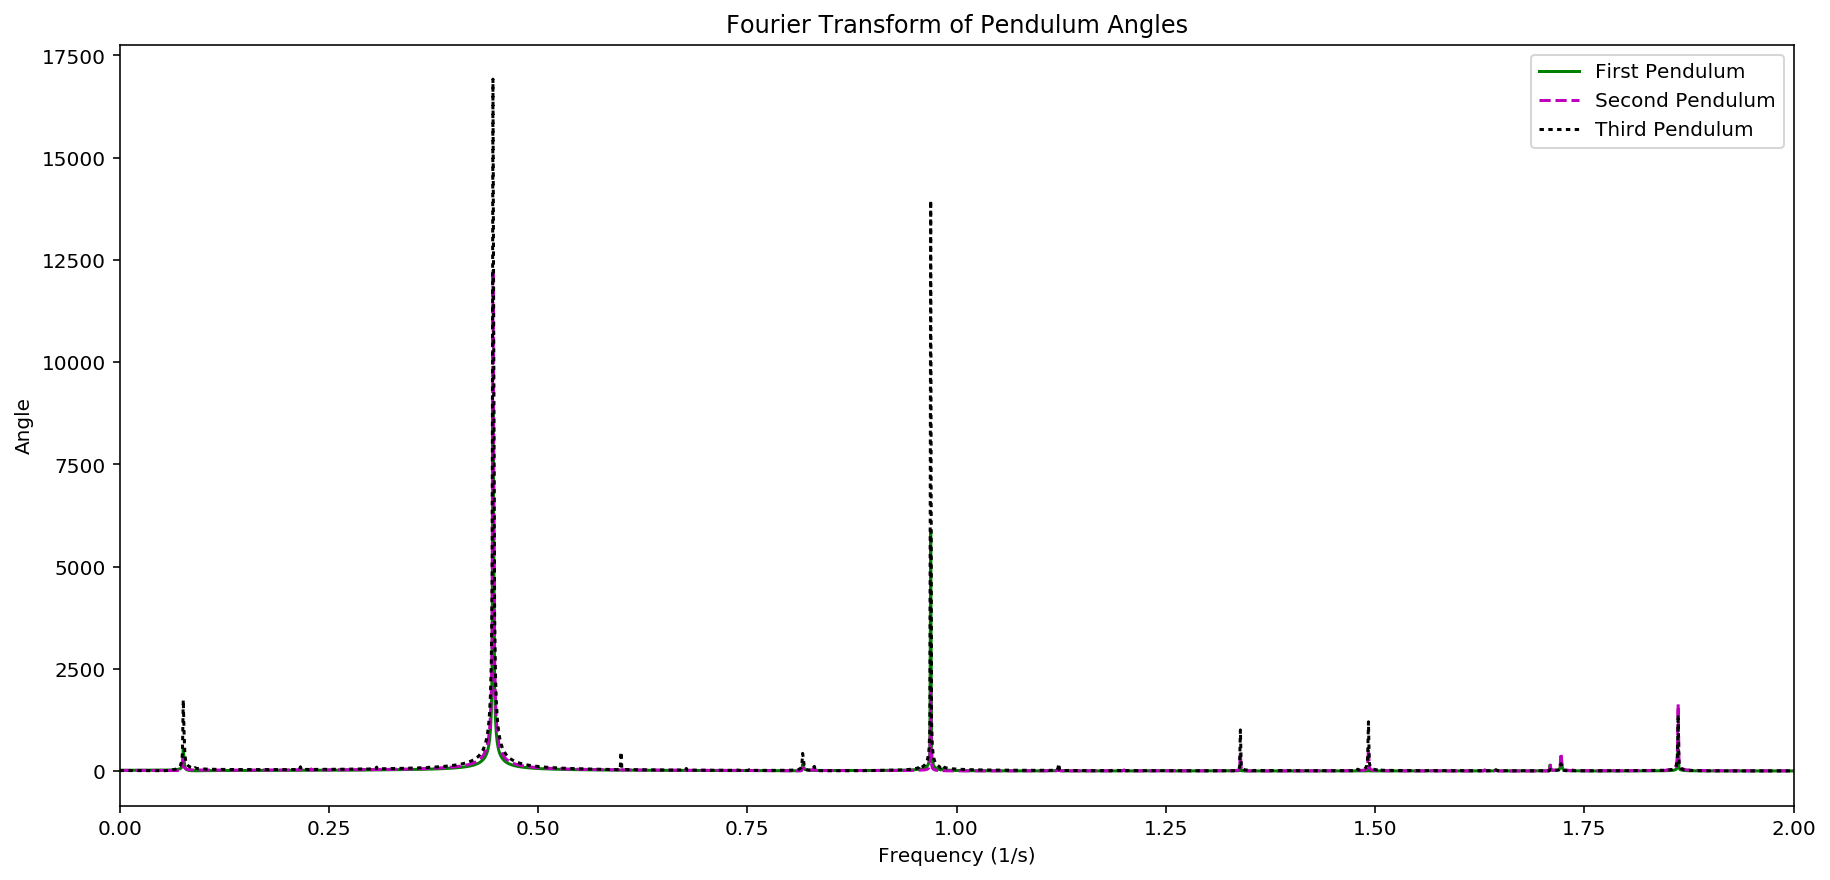

In [44]:
solution = solve_triple_pendulum([0, 0, 0, 0, 0, 7], tmax = 1000, dt = 0.02)
frequency_plot(solution).savefig("figures/fft_periodic.png");

We see that this particular solution has two main frequency components, which tells us the motion of the system is periodic.  We can find the frequency that corresponds to the main peak using the `argmax` function, and then convert that to a period.

In [45]:
# Find the frequency at which the FFT is at a maximum
freq_1 = freqs[argmax(fft_1)]
freq_2 = freqs[argmax(fft_2)]
freq_3 = freqs[argmax(fft_3)]

# Confirm all three pendula have the same frequency
print("Main frequencies are {}equal.".format("" if freq_1 == freq_2 == freq_3 else "not "))

# Calculate period
period = 2*pi / freq_1 
print("Period of main frequency: {:.4f} s".format(period))

Main frequencies are equal.
Period of main frequency: 14.0879 s


### Chaotic Solution

When $\dot\phi_3(0)=12$, the solution is chaotic. We see this as an absence of any peaks in the frequency spectrum except for a massive singularity at 0, which suggests aperiodic motion.

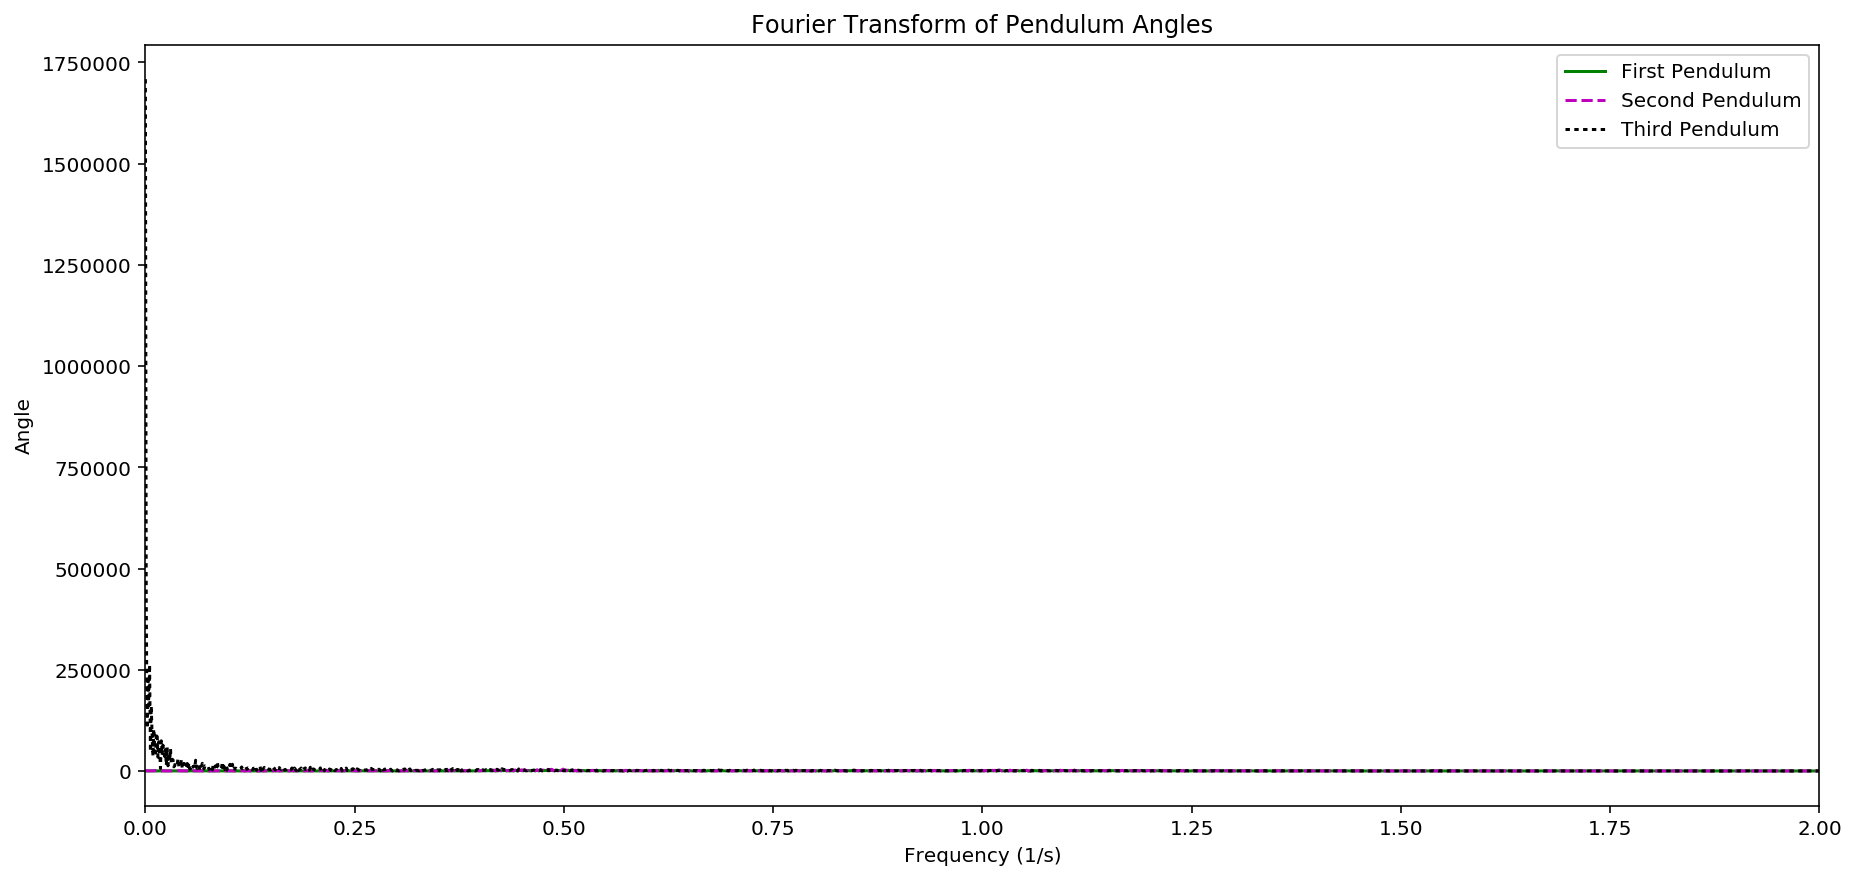

In [46]:
solution = solve_triple_pendulum([0, 0, 0, 0, 0, 12], tmax = 1000, dt = 0.02)
frequency_plot(solution).savefig("figures/fft_chaotic.png");

## “Bifurcation Diagram”

We can explore the conditions under which the triple pendulum system becomes chaotic by making a sort of bifurcation diagram.  Unlike the damped, driven pendulum, there is no natural frequency at which to sample the solution values to generate the diagram.  Instead, we will plot the frequency spectrum for a range of initial angular velocities ($\dot\phi_3$), using color to denote the value of the Fourier transform at each frequency.

In [58]:
def bifurcation_diagram(param, start, end, xSize, ySize, max_freq = 2, xLabel = ""):
    initial_values = linspace(start, end, xSize)
    
    t_max = ySize / max_freq

    dt = 0.05
    steps = int(t_max / dt)
    freqs = fft.rfftfreq(steps, dt) # helper array for conversion to rad/s

    data = zeros((xSize, ySize))


    for step, p_0 in enumerate(initial_values):
        # set up initial conditions vector
        r0 = zeros(6)
        r0[param] = p_0
        # run simulation
        t, phi_1, phi_2, phi_3, _, _, _  = solve_triple_pendulum(r0, tmax=t_max, dt=dt) 

        fft_data = absolute(fft.rfft(phi_3))[ : ySize] # get FFT and discard high frequencies
        data[step, :] = fft_data / max(fft_data) # normalize to this solution's values, concatenate onto our results array

    
    # plot
    figsize(12,7)
    fig = figure()
    imshow(transpose(1 - data), extent=[start, end, 0, freqs[ySize]], origin="lower", 
           interpolation="bilinear", aspect=0.6*(end-start)/freqs[ySize], cmap="gray") # 0=white, 1=black
    xlabel(xLabel)
    ylabel("Frequency of Solution (1/s)")
    
    return fig

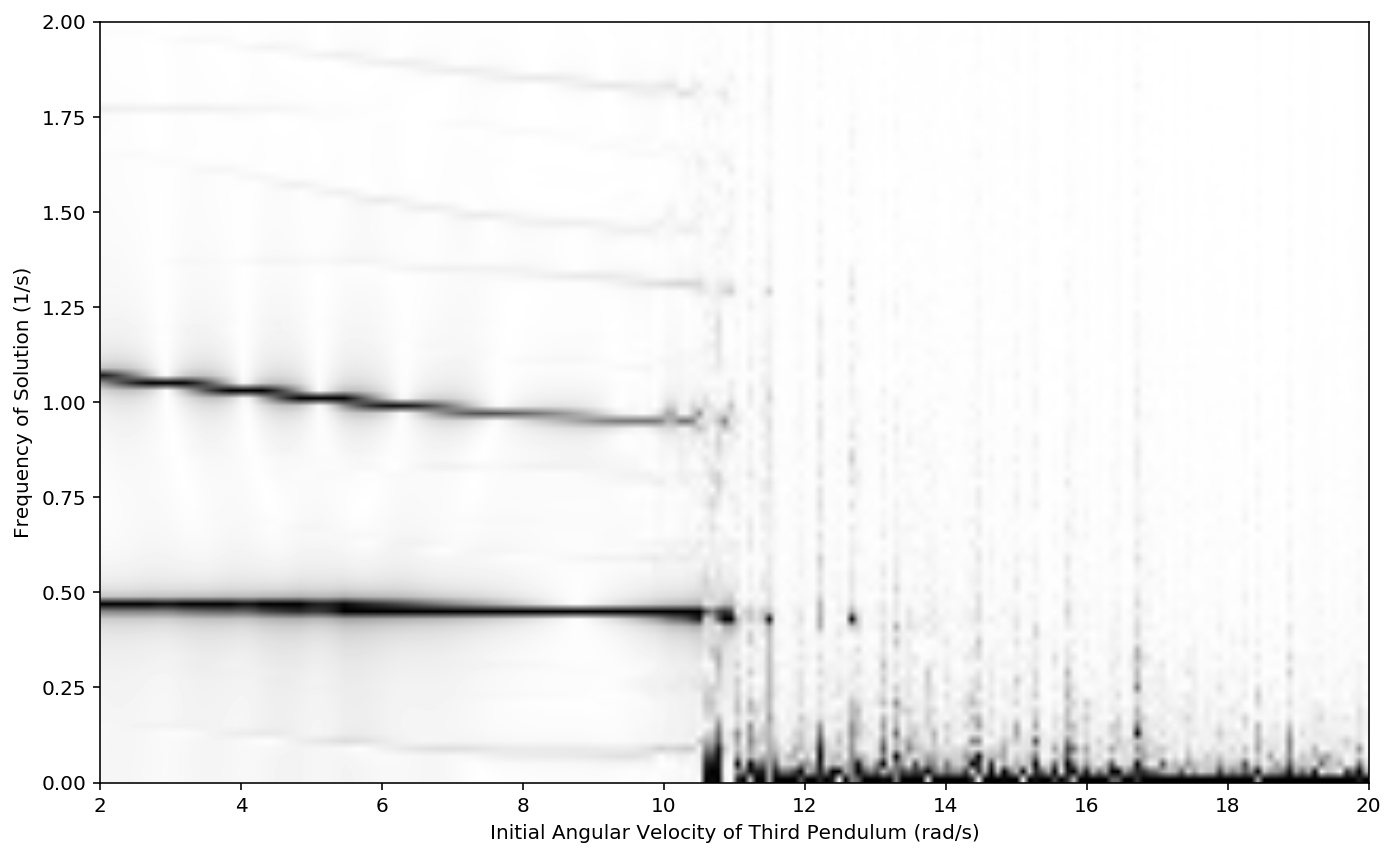

In [59]:
bifurcation_diagram(5, 2, 20, 200, 100, 
    xLabel="Initial Angular Velocity of Third Pendulum (rad/s)").savefig("figures/bifurcation_1.png")